# Chirp frame generator for "chirp" project

May 30, 2018

Reference: https://dzone.com/articles/sound-synthesis-numpy

In [45]:
%matplotlib inline

from numpy import linspace, sin, pi, int16, append
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

In [46]:
SAMPLING_RATE = 48000  # Hz
TQ = 0.0205  # Time quantum in sec
AMPLITUDE = 20000

## Tone synthesis

In [47]:
def chirp(f1, f2, length, amp=1, rate=SAMPLING_RATE):
    t = linspace(0, length, int(length * rate))
    delta = float(f2 - f1)/float(length)
    freq = f1 + delta * t
    data = sin(2 * pi * freq * t) * amp
    return data.astype(int16) # two byte integers

In [48]:
F1 = 16000
F2 = 18000

def tq(level):
    tone = None
    if level >= 1:
        tone = chirp(F1, F2, TQ, amp=AMPLITUDE)
    else:
        tone = chirp(0, 0, TQ, amp=AMPLITUDE)
    return tone

HIGH = 1
LOW = 0

TQ_HIGH = tq(HIGH)
TQ_LOW = tq(LOW)

In [67]:
FRAME_FIELD_LENGTH = {"START_OF_FRAME": 3, "BITS": 2}
TRAILER = 30

def field(level, length):
    tone = None
    tone_ = None
    if level == HIGH:
        tone = TQ_HIGH
        tone_ = TQ_HIGH
    else:
        tone = TQ_LOW
        tone_ = TQ_LOW
    for i in range(length - 1):
        tone = append(tone, tone_)
    return tone

def frame(bits):
    
    field_ = field(HIGH, FRAME_FIELD_LENGTH["START_OF_FRAME"])
    bit_field_length = FRAME_FIELD_LENGTH["BITS"] 
    for bit in bits:
        field_ = append(field_, field(bit, bit_field_length))    
    field_ = append(field_, field(LOW, TRAILER))
           
    return field_

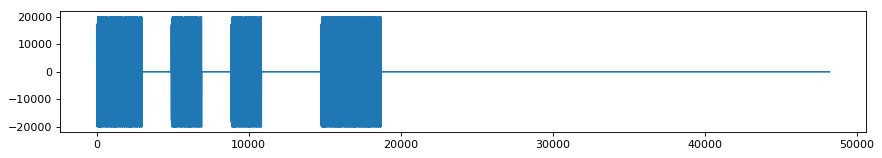

In [68]:
ASCII_S = [0, 1, 0, 1, 0, 0, 1, 1]

tone = frame(ASCII_S)

plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)

In [69]:
WAV_FILE = 'ChirpFrameS.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

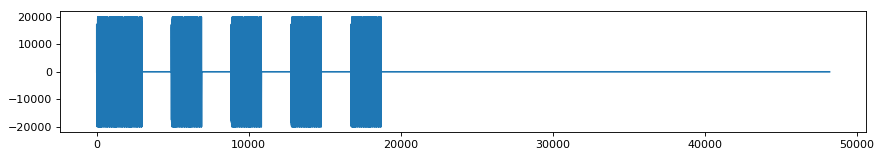

In [70]:
tone = frame([0, 1, 0, 1, 0, 1, 0, 1])

plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameCycle.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

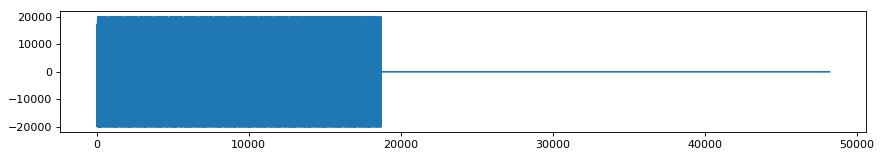

In [71]:
tone = frame([1, 1, 1, 1, 1, 1, 1, 1])

plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameAll.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

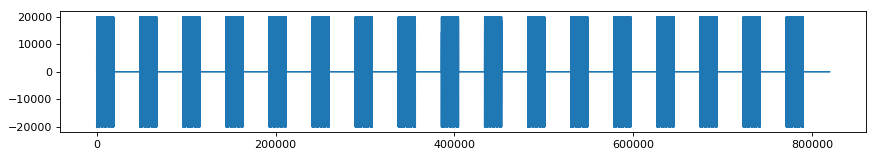

In [72]:
tone = frame([0,1,0,1,0,1,0,1])
for i in range(16):
    tone = append(tone, frame([0,1,0,1,0,1,0,1]))
    
plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameRepeat.wav'
write(WAV_FILE, SAMPLING_RATE, tone)